In [1]:
access_token = ''
# !pip install huggingface_hub
!python -c "from huggingface_hub.hf_api import HfFolder; HfFolder.save_token('put token here')"

# - how to retrieve access token?
#    - https://youtu.be/OFed5PdDAJI?t=784

In [2]:
# !pip install datasets

# Load and Understand the Dataset

In [3]:
from datasets import load_dataset
emotions = load_dataset("dair-ai/emotion")

In [4]:
import pandas as pd
emotions.set_format(type="pandas")
df=emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [5]:
def label_int_to_str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int_to_str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [6]:
emotions_l = ['sadness', 'anger', 'love', 'surprise', 'fear', 'joy']
class_int2str = {}
class_str2int = {}
for emotion in emotions_l:
    fc = df['label_name'] == emotion
    class_num = df.loc[fc, 'label'].values[0]
    class_str2int[emotion] = class_num
    class_int2str[class_num] = emotion 

for k, v in class_int2str.items():
    print(k, v)
print()
for k, v in class_str2int.items():
    print(k, v)
print()
class_l = [class_int2str.get(i) for i in range(len(class_int2str.items()))]
print(class_l)

0 sadness
3 anger
2 love
5 surprise
4 fear
1 joy

sadness 0
anger 3
love 2
surprise 5
fear 4
joy 1

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


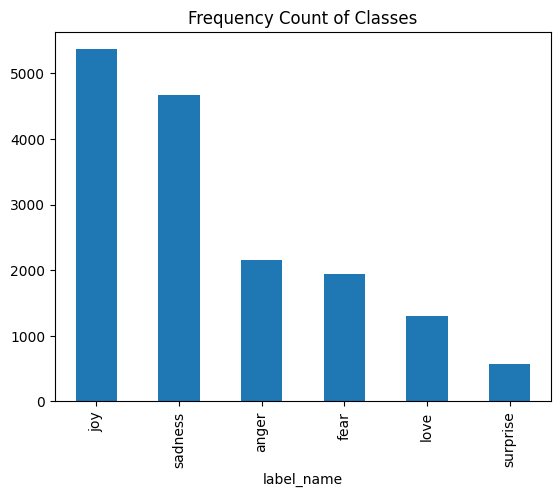

In [7]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=False).plot.bar()
plt.title("Frequency Count of Classes")
plt.show()

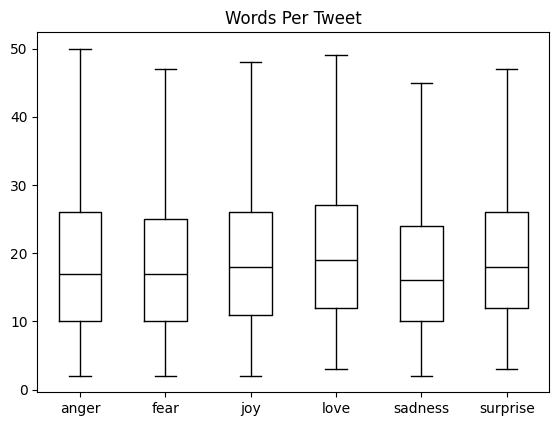

In [8]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid = False, showfliers = False, color = "black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [9]:
emotions.reset_format()

# Data Preprocessing

In [10]:
# !pip install --upgrade pip

In [11]:
# !pip install -q transformers

In [12]:
# from transformers import AutoTokenizer

# model_ckpt = "distilbert-base-uncased"
# tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [15]:
# test
from transformers import DistilBertTokenizer

model_ckpt = "distilbert-base-uncased"
distbert_tokenize = DistilBertTokenizer.from_pretrained(model_ckpt)

sample_text = "This is Hello World!"
encoded_text = distbert_tokenize(sample_text)
print(encoded_text)
tokens = distbert_tokenize.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

{'input_ids': [101, 2023, 2003, 7592, 2088, 999, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}
['[CLS]', 'this', 'is', 'hello', 'world', '!', '[SEP]']


In [16]:
# tokenizer attributes
distbert_tokenize.convert_tokens_to_string(tokens)
print(distbert_tokenize.vocab_size)
print(distbert_tokenize.model_max_length)

30522
512


## Tokenizing the entire dataset

In [24]:
from transformers import DistilBertTokenizer

model_ckpt = "distilbert-base-uncased"
distbert_tokenize = DistilBertTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return distbert_tokenize(batch["text"], truncation=True)

# check
idxs = [0, 1, 2]
for idx in idxs:
    print(emotions["train"][idx])
    print(class_int2str.get(emotions["train"][idx].get('label')))
    print(tokenize(emotions["train"][idx]), '\n')

{'text': 'i didnt feel humiliated', 'label': 0}
sadness
{'input_ids': [101, 1045, 2134, 2102, 2514, 26608, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]} 

{'text': 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'label': 0}
sadness
{'input_ids': [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]} 

{'text': 'im grabbing a minute to post i feel greedy wrong', 'label': 3}
anger
{'input_ids': [101, 10047, 9775, 1037, 3371, 2000, 2695, 1045, 2514, 20505, 3308, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]} 



In [25]:
# Now we tokenise the entire dataset
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

## Padding

In [26]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer = distbert_tokenize)

In [27]:
emotions_encoded["train"].column_names

['text', 'label', 'input_ids', 'attention_mask']

# Train BERT-based Model

In [31]:
import torch
from transformers import AutoModelForSequenceClassification

num_labels = len(class_l)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Evaluate

In [ ]:
# !pip install -q evaluate

In [32]:
import evaluate
import numpy as np

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, 
                           references = labels)

In [ ]:
# !pip install ipywidgets

In [ ]:
# !pip install transformers[torch]

### Logging to HuggingFace

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

## Setting Training Arguments

In [33]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="distilbert-emotion",
    num_train_epochs = 3,   
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy = "epoch",
    load_best_model_at_end = True,
    push_to_hub = True,
    report_to = "none"    
)

In [35]:
from transformers import Trainer

trainer = Trainer(
    model = model,
    args = training_args,
    compute_metrics = compute_metrics,
    train_dataset = emotions_encoded["train"],
    eval_dataset = emotions_encoded["validation"],
    tokenizer = distbert_tokenize
)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.195365,0.926000
2,0.349400,0.147217,0.937000
3,0.349400,0.133256,0.938500


TrainOutput(global_step=750, training_loss=0.26405045064290367, metrics={'train_runtime': 7273.3781, 'train_samples_per_second': 6.599, 'train_steps_per_second': 0.103, 'total_flos': 702110735472384.0, 'train_loss': 0.26405045064290367, 'epoch': 3.0})

# Evaluate Performance

## Predicting the validation dataset

In [36]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [37]:
preds_output.metrics

{'test_loss': 0.13325634598731995,
 'test_accuracy': 0.9385,
 'test_runtime': 99.0135,
 'test_samples_per_second': 20.199,
 'test_steps_per_second': 0.323}

# Confusion Matrix

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

y_preds = np.argmax(preds_output.predictions, axis=1)

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize = "true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, 
                                 display_labels=labels)
    disp.plot(cmap="Blues", values_format = ".2f", ax = ax,
             colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

In [39]:
y_valid = np.array(emotions_encoded["validation"]["label"])
labels = emotions["train"].features["label"].names

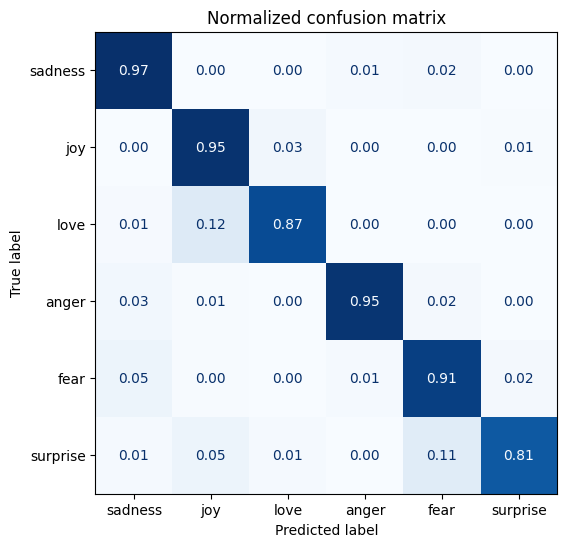

In [40]:
plot_confusion_matrix(y_preds, y_valid, labels)

In [41]:
trainer.push_to_hub(commit_message="Training completed! - 3 epochs")

'https://huggingface.co/richardchai/distilbert-emotion/tree/main/'

# Download the Trained Model from HuggingFaceHub and Predict

In [42]:
from transformers import pipeline

model_id = "richardchai/distilbert-emotion"
classifier = pipeline("text-classification", model= model_id)

C:\py310\ML_01\lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\richa\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


C:\py310\ML_01\lib\site-packages\transformers\pipelines\text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


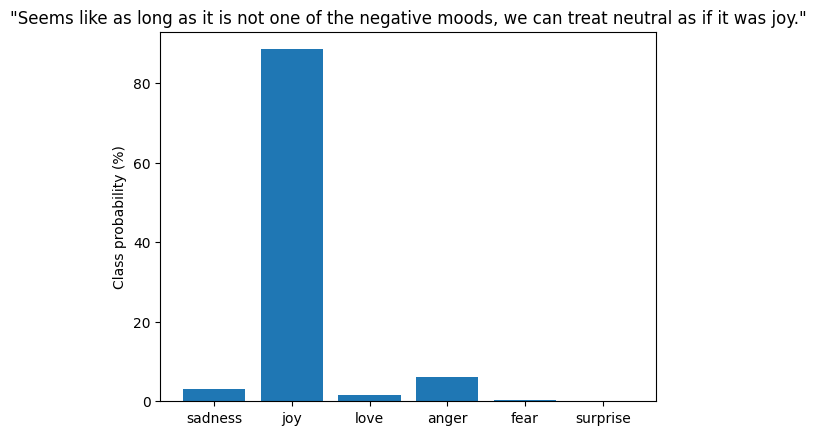

In [43]:
# custom_text="what isn't there a neutral mood?"  # hmmmm.
# custom_text="i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake."
# custom_text="i am feeling so damned hopeful just from being around someone who cares and is awake."
# custom_text="I just want to sleep in today"
custom_text="Seems like as long as it is not one of the negative moods, we can treat neutral as if it was joy."

preds=classifier(custom_text, return_all_scores = True)
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100*preds_df["score"])
plt.title(f'"{custom_text}"')
plt.ylabel("Class probability (%)")
plt.show()

In [64]:
class_int2str

{0: 'sadness', 3: 'anger', 2: 'love', 5: 'surprise', 4: 'fear', 1: 'joy'}

In [101]:
from typing import List
from dataclasses import dataclass

@dataclass
class prediction_dc:
    label_num: int
    label_name: str
    label_score: float

    def __gt__(self, other):
        return (self.label_score > other.label_score)

    def __eq__(self, other):
        return (self.label_score == other.label_score)


sample_texts = [
    'i feel especially strongly about this since i have hated my teeth forever i was one of the unlucky ones who got bad genetics and an even worst orthodontist and pediatric dentist',
    'i feel like we barely know each other and time just isnt being generous with our love',
    'i was feeling extremely shitty physically this morning',
    'i looked around and once again was disappointed that so little had shown up this evening but apparently this was my day to feel selfish',
    'i feel a bit strange publishing these beautiful photos',
    'i promised myself that i wont enter anymore giveaways because i feel greedy but i couldnt resist this one',
    'i feel like im almost uh afraid of everything so to speak',
    'i was feeling abnormally wimpy so i staked out my bird feeder',
    'i feel like my trust is being abused the less i feel like theres a future for us',
    'i still feel sleep deprived she is almost sleeping through the night giving us',
    "I've been waiting so long for this day, finally, it's here!"
]

def pred_results(labels_d: dict, preds: list, top_k=-1, desc=True, verbose=False) -> List[prediction_dc]:
    """
    preds is a list of dict (k is 'label', v is 'score')
        format: 
            'label': 'LABEL_N':str e.g. LABEL_0 or LABEL_1 ... LABEL_N
            'score': float
    if verbose: print all results
    returns a list of dicts of label_name:score, sorted from highest score to lowest score 
    """
    prediction_dc_l = []
    for pred in preds:
        for i in range(len(labels_d)):
            if str(i) in pred.get('label'):
                class_num = i
                class_name = labels_d.get(class_num)
                class_score = pred.get('score')
                # print(class_num, class_name, class_score)
                prediction_dc_l.append(prediction_dc(label_num=class_num, label_name=class_name, label_score=class_score))
    if desc:
        prediction_dc_l = sorted(prediction_dc_l, reverse=True)
    else:
        prediction_dc_l = sorted(prediction_dc_l, reverse=False)
        
    if verbose:
        for pdc in prediction_dc_l:
            print(pdc)
    if top_k==-1:
        return prediction_dc_l
    else:
        return prediction_dc_l[:top_k]
            

for text in sample_texts:
    preds=classifier(text, return_all_scores = True)
    print(text)  # class_int2str
    top_k_results = pred_results(class_int2str, preds[0], top_k=3, desc=True, verbose=False)
    # print(f"\tEmotion classified as: {top_k_results[0].get('class_name')} : {top_k_results[0].get('score')}")

    for k in top_k_results:
        print(f"{k.label_name} ({k.label_num}) \t--> \t{round(k.label_score, 2)}")
    print('-'*100, '\n')

i feel especially strongly about this since i have hated my teeth forever i was one of the unlucky ones who got bad genetics and an even worst orthodontist and pediatric dentist
anger (3) 	--> 	0.74
sadness (0) 	--> 	0.25
love (2) 	--> 	0.01
---------------------------------------------------------------------------------------------------- 

i feel like we barely know each other and time just isnt being generous with our love
love (2) 	--> 	0.73
joy (1) 	--> 	0.27
surprise (5) 	--> 	0.0
---------------------------------------------------------------------------------------------------- 

i was feeling extremely shitty physically this morning
sadness (0) 	--> 	1.0
anger (3) 	--> 	0.0
joy (1) 	--> 	0.0
---------------------------------------------------------------------------------------------------- 

i looked around and once again was disappointed that so little had shown up this evening but apparently this was my day to feel selfish
anger (3) 	--> 	0.99
sadness (0) 	--> 	0.0
fear (4